<a href="https://colab.research.google.com/github/albuut/Medical-Malpractice-Analysis/blob/DTRegression/CS203_PROJECT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Medical Malpractice Analysis



# Google Colab Startup
Make sure to clone the repository into the Google Colab.

In [2]:
!git clone https://github.com/albuut/Medical-Malpractice-Analysis.git

Cloning into 'Medical-Malpractice-Analysis'...
remote: Enumerating objects: 161, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 161 (delta 24), reused 12 (delta 10), pack-reused 126
Receiving objects: 100% (161/161), 724.27 KiB | 11.14 MiB/s, done.
Resolving deltas: 100% (81/81), done.


Run the following code.

In [3]:
%cd /content/Medical-Malpractice-Analysis/

/content/Medical-Malpractice-Analysis


# Data Cleaning

Data manipulated from the origional data set

1. Amount: Log(Amount)

2. Speciality: Dummy variable encoded into different specialities.

3. Insurance: Dummy variable enconded into different insurances.

4. Marital Status: Dummy variabled econded into different marital status.

5. Gender: One hot encoded gender for Male = 0 and Female = 1.




We can use the following lines to generate the cleaned up data from csv file with different log values down below.

In [6]:
!python process_data.py medicalmalpractice.csv log10_data 10
!python process_data.py medicalmalpractice.csv log2_data 2
!python process_data.py medicalmalpractice.csv ln_data ln

Successfully written data to: log10_data_train.csv
Successfully written data to: log10_data_validate.csv
Successfully written data to: log10_data_test.csv
Successfully written data to: log2_data_train.csv
Successfully written data to: log2_data_validate.csv
Successfully written data to: log2_data_test.csv
Successfully written data to: ln_data_train.csv
Successfully written data to: ln_data_validate.csv
Successfully written data to: ln_data_test.csv


We then display the origonal data down below.

In [7]:
import pandas as pd
df_origional = pd.read_csv('medicalmalpractice.csv')
df_origional

,Amount,Severity,Age,Private Attorney,Marital Status,Specialty,Insurance,Gender
0,57041,7,62,1,2,Family Practice,Private,Male
1,324976,6,38,1,2,OBGYN,No Insurance,Female
2,135383,4,34,1,2,Cardiology,Unknown,Male
3,829742,7,42,1,1,Pediatrics,No Insurance,Female
4,197675,3,60,0,2,OBGYN,Medicare/Medicaid,Female
...,...,...,...,...,...,...,...,...
79205,25305,4,64,1,2,General Surgery,Unknown,Male
79206,43098,3,87,0,4,Orthopedic Surgery,Unknown,Male
79207,35398,3,81,0,4,Anesthesiology,Unknown,Male
79208,154228,9,19,0,4,Dermatology,Unknown,Female


We can then observe how the data is cleaned and seperated into different variables to be used in different forms of regression or analysis.

In [ ]:
import pandas as pd
df_log10 = pd.read_csv('log10_data_train.csv')
df_log10

,Amount,log_Amount,Severity,Age,Private Attorney,Gender,Anesthesiology,Cardiology,Dermatology,Emergency Medicine,...,Thoracic Surgery,Urological Surgery,Medicare/Medicaid,No Insurance,Private,Workers Compensation,Divorced,Single,Married,Widowed
0,95178,4.978537,3,30,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
1,96692,4.985391,7,66,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
2,83883,4.923674,3,23,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
3,12605,4.100543,4,69,0,1,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
4,571863,5.757292,7,17,1,1,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29519,67006,4.826114,3,16,0,1,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
29520,13604,4.133667,4,67,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
29521,19281,4.285130,4,48,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
29522,417274,5.620421,6,20,1,1,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0


# Decision Tree Regression

In [4]:
!git checkout DTRegression

Branch 'DTRegression' set up to track remote branch 'DTRegression' from 'origin'.
Switched to a new branch 'DTRegression'


6581.386902719758
5247.1701542204
0.0319829803084478
0.9744859480348071
7254.665782920405
4853.82831949029
-0.010290255638887424
0.9917898131004527


[Text(0.5, 0.9166666666666666, 'x[1] <= 12.502\npoisson = 92279.63\nsamples = 29524\nvalue = 187770.123'),
 Text(0.25, 0.75, 'x[1] <= 11.291\npoisson = 15943.41\nsamples = 23894\nvalue = 94183.457'),
 Text(0.125, 0.5833333333333334, 'x[1] <= 10.563\npoisson = 5387.792\nsamples = 10345\nvalue = 43562.309'),
 Text(0.0625, 0.4166666666666667, 'x[1] <= 9.827\npoisson = 2381.577\nsamples = 4479\nvalue = 23879.299'),
 Text(0.03125, 0.25, 'x[1] <= 9.078\npoisson = 1169.648\nsamples = 1294\nvalue = 10870.021'),
 Text(0.015625, 0.08333333333333333, 'poisson = 431.479\nsamples = 431\nvalue = 5181.889'),
 Text(0.046875, 0.08333333333333333, 'poisson = 272.255\nsamples = 863\nvalue = 13710.791'),
 Text(0.09375, 0.25, 'x[0] <= 28548.0\npoisson = 518.176\nsamples = 3185\nvalue = 29164.7'),
 Text(0.078125, 0.08333333333333333, 'poisson = 148.425\nsamples = 1470\nvalue = 24094.627'),
 Text(0.109375, 0.08333333333333333, 'poisson = 124.55\nsamples = 1715\nvalue = 33510.478'),
 Text(0.1875, 0.4166666666

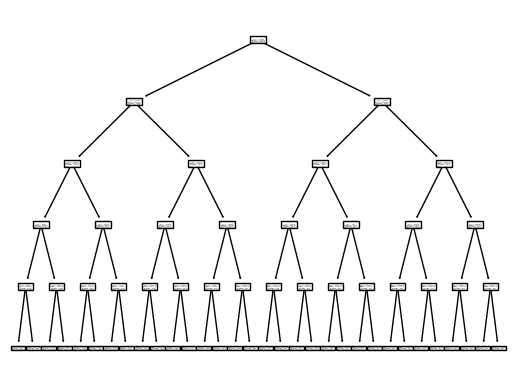

In [65]:
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import ttest_ind
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

ln_X_train = pd.read_csv('ln_data_train.csv')
ln_X_validate = pd.read_csv('ln_data_validate.csv')
ln_X_test = pd.read_csv('ln_data_test.csv')
ln_Y_train = ln_X_train['Amount']
ln_Y_validate = ln_X_validate['Amount']
ln_Y_test = ln_X_test['Amount']


ln_model = DecisionTreeRegressor(max_depth = 5, random_state=1)
ln_model_proposed = DecisionTreeRegressor(criterion= "poisson", max_depth = 5, random_state=1)

ln_model.fit(ln_X_train, ln_Y_train)
ln_model_proposed.fit(ln_X_train, ln_Y_train)

ln_pred = ln_model.predict(ln_X_validate)
ln_pred_proposed = ln_model_proposed.predict(ln_X_validate)

ln_Y_validate_arr = ln_Y_validate.to_numpy()

ln_rmse = np.sqrt(mean_squared_error(ln_Y_validate, ln_pred))
ln_mae = mean_absolute_error(ln_Y_validate, ln_pred)

ln_rmse_proposed = np.sqrt(mean_squared_error(ln_Y_validate, ln_pred_proposed))
ln_mae_proposed = mean_absolute_error(ln_Y_validate, ln_pred_proposed)



ln_t_statistic, ln_p_value = ttest_ind(ln_Y_validate_arr, ln_pred)
ln_t_statistic_proposed, ln_p_value_proposed = ttest_ind(ln_Y_validate_arr, ln_pred_proposed)


print(ln_rmse)
print(ln_mae)
print(ln_t_statistic)
print(ln_p_value)

print(ln_rmse_proposed)
print(ln_mae_proposed)
print(ln_t_statistic_proposed)
print(ln_p_value_proposed)

#ln_Y_test_arr = ln_Y_test.to_numpy()

#ln_pred = ln_model.predict(ln_X_test)

#ln_rmse = np.sqrt(mean_squared_error(ln_Y_test, ln_pred))

#ln_mae = mean_absolute_error(ln_Y_test, ln_pred)

#ln_t_statistic, ln_p_value = ttest_ind(ln_Y_test_arr, ln_pred)

#fig, ax = plt.subplots()

#ax.bar(['RMSE-ln','MAE-ln'], [ln_rmse, ln_mae])
#ax.set_ylabel('Error')
#ax.set_title('Error for Decision Tree Regression')
#print(ln_rmse)
#print(ln_mae)
#print(ln_t_statistic)
#print(ln_p_value)

plot_tree(ln_model_proposed)